In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import tensorflow as tf


### Define and Filter the Classes

We start by defining the classes available in the CIFAR-10 dataset. The dataset contains 10 classes: 'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', and 'truck'. However, we are only interested in four of these classes: 'car', 'frog', 'horse', and 'ship'. The corresponding indices for these classes are [1, 6, 7, 8].


In [2]:
# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# ---------------------- Filter to our wanted classes only ---------------------
# Define the classes you want to keep (e.g., class 0 and class 1)
classes = ('car', 'frog', 'horse', 'ship')
classes_to_keep = [1, 6, 7, 8]


### Dataset Transformation

Next, we define a transformation that will be applied to the CIFAR-10 dataset. The `transforms.Compose()` method chains two operations: converting the images to tensors and normalizing the pixel values to have a mean of 0.5 and standard deviation of 0.5 for each color channel. This helps the model to train more efficiently by normalizing the input data.



In [3]:
# Define the transformation for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

### Loading the CIFAR-10 Dataset

Here, we load the CIFAR-10 dataset using the `datasets.CIFAR10()` function provided by PyTorch. We load both the training and test datasets, specifying the root directory where the data will be stored and applying the transformations we defined earlier. If the dataset is not already downloaded, it will be automatically retrieved.


In [4]:
# Load the CIFAR-10 dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


100%|██████████| 170498071/170498071 [02:19<00:00, 1219835.97it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Filtering the Dataset by Class

We define a function, `filter_dataset_by_class()`, that filters the dataset to only include the specified classes. The function works by creating a mask that identifies which data points belong to the desired classes and then filters both the data and the targets accordingly. The `filtered_targets` array is updated to reflect the indices of the selected classes.


In [5]:
# Function to filter the dataset by the specified classes
def filter_dataset_by_class(dataset, classes):
    # Get the data and targets
    data, targets = dataset.data, torch.tensor(dataset.targets)

    # Create a mask for the classes you want to keep
    mask = torch.isin(targets, torch.tensor(classes))

    # Filter the data and targets
    filtered_data = data[mask.numpy()]
    filtered_targets = targets[mask].numpy()

    for i in range(len(filtered_targets)):
      filtered_targets[i] = classes.index(filtered_targets[i])

    # Update the dataset's data and targets
    dataset.data = filtered_data
    dataset.targets = filtered_targets


### Checking Dataset Sizes Before and After Filtering

We print out the size of the unfiltered training and test sets before applying any filtering. This helps us understand the original number of samples in the datasets. After filtering, we again print the sizes of the datasets to confirm that the filtering was applied correctly.


In [6]:
# Size of the unfiltered sets
print(f'Unfiltered train set size: {len(trainset)}')
print(f'Unfiltered test set size: {len(testset)}')
print(f'Unfiltered classes: {trainset.classes}')

# Filter the train and test sets
filter_dataset_by_class(trainset, classes_to_keep)
filter_dataset_by_class(testset, classes_to_keep)

# Now the trainset and testset objects are still CIFAR10 datasets, but only contain the selected classes
print(f'Filtered train set size: {len(trainset)}')
print(f'Filtered test set size: {len(testset)}')
print(f'Filtered classes: {trainset.classes}')


Unfiltered train set size: 50000
Unfiltered test set size: 10000
Unfiltered classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Filtered train set size: 20000
Filtered test set size: 4000
Filtered classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Creating DataLoaders for the Filtered Dataset

After filtering the datasets, we use the `DataLoader` class to create loaders for both the training and test sets. These loaders allow us to efficiently iterate through the datasets in mini-batches, which is critical for training and testing our models.


In [7]:
# Create DataLoader for the filtered datasets
batch_size = 4
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


### Iterating Through the DataLoader

Finally, we demonstrate how to iterate through the `trainloader` to retrieve mini-batches of images and labels. This helps us verify that the filtering and loading of the dataset are functioning as expected.


In [8]:
# Example: Iterate through the filtered trainloader
for i, (images, labels) in enumerate(trainloader):
    print(f'Batch size: {images.size(0)}, Labels: {labels}')
    if i == 3:
      break

print(trainset)
print(testset)

Batch size: 4, Labels: tensor([3, 2, 1, 2])
Batch size: 4, Labels: tensor([2, 0, 2, 2])
Batch size: 4, Labels: tensor([3, 3, 3, 2])
Batch size: 4, Labels: tensor([0, 3, 1, 3])
Dataset CIFAR10
    Number of datapoints: 20000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dataset CIFAR10
    Number of datapoints: 4000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


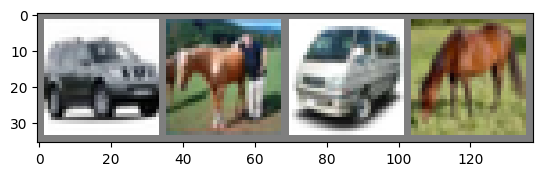

car   horse car   horse


In [9]:
classes = ('car', 'frog', 'horse', 'ship')
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Neural Network Architectures

In this section, we define multiple neural network architectures using the `nn.Module` class from PyTorch. Each architecture varies in terms of the number of parameters and the number of layers, including convolutional layers, fully connected layers, and pooling layers. These networks are designed to process image data (with 3 input channels, typically corresponding to RGB images) and output predictions for 4 different classes.

The networks are organized based on the total number of parameters (e.g., `Net_10608`, `Net_36480`, etc.). For each network:

- **Convolutional Layers (`conv1`, `conv2`)**: These layers apply filters to the input images to learn spatial hierarchies of features.
- **Pooling Layers (`pool`)**: Max pooling layers are used to downsample the feature maps, reducing the spatial dimensions.
- **Fully Connected Layers (`fc1`, `fc2`, `fc3`)**: These layers transform the output of the convolutional layers into final predictions.

Each network is designed to map from the image input space to a 4-class output space, and different configurations allow us to experiment with models of varying complexity.

We store these models in a dictionary `models_to_train` to easily reference and use them later for training and evaluation.

In [11]:
def Net_36480():
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(3, 6, 5)  # Conv layer with 6 output channels, kernel size 5x5
            self.pool = nn.MaxPool2d(2, 2)   # Max pooling layer with 2x2 window
            self.conv2 = nn.Conv2d(6, 10, 5)  # Conv layer with 10 output channels, kernel size 5x5
            self.fc1 = nn.Linear(10 * 5 * 5, 110)  # Fully connected layer with 110 output units
            self.fc2 = nn.Linear(110, 60)  # Fully connected layer with 60 output units
            self.fc3 = nn.Linear(60, 4)   # Fully connected layer with 4 output units (for classification)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))  # Apply conv1, ReLU, and pooling
            x = self.pool(F.relu(self.conv2(x)))  # Apply conv2, ReLU, and pooling
            x = torch.flatten(x, 1)  # Flatten the output from the conv layers
            x = F.relu(self.fc1(x))  # Apply fc1 with ReLU
            x = F.relu(self.fc2(x))  # Apply fc2 with ReLU
            x = self.fc3(x)  # Apply fc3 (output layer)
            return x

    return Net()

def Net_10608():
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(3, 6, 5)  # Conv layer with 6 output channels, kernel size 5x5
            self.pool = nn.MaxPool2d(2, 2)   # Max pooling layer with 2x2 window
            self.conv2 = nn.Conv2d(6, 6, 5)  # Conv layer with 6 output channels, kernel size 5x5
            self.fc1 = nn.Linear(6 * 5 * 5, 40)  # Fully connected layer with 40 output units
            self.fc2 = nn.Linear(40, 20)  # Fully connected layer with 20 output units
            self.fc3 = nn.Linear(20, 4)   # Fully connected layer with 4 output units (for classification)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))  # Apply conv1, ReLU, and pooling
            x = self.pool(F.relu(self.conv2(x)))  # Apply conv2, ReLU, and pooling
            x = torch.flatten(x, 1)  # Flatten the output from the conv layers
            x = F.relu(self.fc1(x))  # Apply fc1 with ReLU
            x = F.relu(self.fc2(x))  # Apply fc2 with ReLU
            x = self.fc3(x)  # Apply fc3 (output layer)
            return x

    return Net()

def Net_13093():
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(3, 6, 5)  # Conv layer with 6 output channels, kernel size 5x5
            self.pool = nn.MaxPool2d(2, 2)   # Max pooling layer with 2x2 window
            self.conv2 = nn.Conv2d(6, 8, 5)  # Conv layer with 8 output channels, kernel size 5x5
            self.fc1 = nn.Linear(8 * 5 * 5, 50)  # Fully connected layer with 50 output units
            self.fc2 = nn.Linear(50, 25)  # Fully connected layer with 25 output units
            self.fc3 = nn.Linear(25, 4)   # Fully connected layer with 4 output units (for classification)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))  # Apply conv1, ReLU, and pooling
            x = self.pool(F.relu(self.conv2(x)))  # Apply conv2, ReLU, and pooling
            x = torch.flatten(x, 1)  # Flatten the output from the conv layers
            x = F.relu(self.fc1(x))  # Apply fc1 with ReLU
            x = F.relu(self.fc2(x))  # Apply fc2 with ReLU
            x = self.fc3(x)  # Apply fc3 (output layer)
            return x

    return Net()

def Net_15895():
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(3, 6, 5)  # Conv layer with 6 output channels, kernel size 5x5
            self.pool = nn.MaxPool2d(2, 2)   # Max pooling layer with 2x2 window
            self.conv2 = nn.Conv2d(6, 10, 5)  # Conv layer with 10 output channels, kernel size 5x5
            self.fc1 = nn.Linear(10 * 5 * 5, 50)  # Fully connected layer with 50 output units
            self.fc2 = nn.Linear(50, 25)  # Fully connected layer with 25 output units
            self.fc3 = nn.Linear(25, 4)   # Fully connected layer with 4 output units (for classification)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))  # Apply conv1, ReLU, and pooling
            x = self.pool(F.relu(self.conv2(x)))  # Apply conv2, ReLU, and pooling
            x = torch.flatten(x, 1)  # Flatten the output from the conv layers
            x = F.relu(self.fc1(x))  # Apply fc1 with ReLU
            x = F.relu(self.fc2(x))  # Apply fc2 with ReLU
            x = self.fc3(x)  # Apply fc3 (output layer)
            return x

    return Net()

def Net_39590():
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(3, 6, 5)  # Conv layer with 6 output channels, kernel size 5x5
            self.pool = nn.MaxPool2d(2, 2)   # Max pooling layer with 2x2 window
            self.conv2 = nn.Conv2d(6, 10, 5)  # Conv layer with 10 output channels, kernel size 5x5
            self.fc1 = nn.Linear(10 * 5 * 5, 120)  # Fully connected layer with 120 output units
            self.fc2 = nn.Linear(120, 60)  # Fully connected layer with 60 output units
            self.fc3 = nn.Linear(60, 4)   # Fully connected layer with 4 output units (for classification)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))  # Apply conv1, ReLU, and pooling
            x = self.pool(F.relu(self.conv2(x)))  # Apply conv2, ReLU, and pooling
            x = torch.flatten(x, 1)  # Flatten the output from the conv layers
            x = F.relu(self.fc1(x))  # Apply fc1 with ReLU
            x = F.relu(self.fc2(x))  # Apply fc2 with ReLU
            x = self.fc3(x)  # Apply fc3 (output layer)
            return x

    return Net()

def Net_23299():
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(3, 6, 5)  # Conv layer with 6 output channels, kernel size 5x5
            self.pool = nn.MaxPool2d(2, 2)   # Max pooling layer with 2x2 window
            self.conv2 = nn.Conv2d(6, 9, 5)  # Conv layer with 9 output channels, kernel size 5x5
            self.fc1 = nn.Linear(9 * 5 * 5, 80)  # Fully connected layer with 80 output units
            self.fc2 = nn.Linear(80, 40)  # Fully connected layer with 40 output units
            self.fc3 = nn.Linear(40, 4)   # Fully connected layer with 4 output units (for classification)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))  # Apply conv1, ReLU, and pooling
            x = self.pool(F.relu(self.conv2(x)))  # Apply conv2, ReLU, and pooling
            x = torch.flatten(x, 1)  # Flatten the output from the conv layers
            x = F.relu(self.fc1(x))  # Apply fc1 with ReLU
            x = F.relu(self.fc2(x))  # Apply fc2 with ReLU
            x = self.fc3(x)  # Apply fc3 (output layer)
            return x

    return Net()

def Net_27150():
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(3, 6, 5)  # Conv layer with 6 output channels, kernel size 5x5
            self.pool = nn.MaxPool2d(2, 2)   # Max pooling layer with 2x2 window
            self.conv2 = nn.Conv2d(6, 10, 5)  # Conv layer with 10 output channels, kernel size 5x5
            self.fc1 = nn.Linear(10 * 5 * 5, 80)  # Fully connected layer with 80 output units
            self.fc2 = nn.Linear(80, 60)  # Fully connected layer with 60 output units
            self.fc3 = nn.Linear(60, 4)   # Fully connected layer with 4 output units (for classification)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))  # Apply conv1, ReLU, and pooling
            x = self.pool(F.relu(self.conv2(x)))  # Apply conv2, ReLU, and pooling
            x = torch.flatten(x, 1)  # Flatten the output from the conv layers
            x = F.relu(self.fc1(x))  # Apply fc1 with ReLU
            x = F.relu(self.fc2(x))  # Apply fc2 with ReLU
            x = self.fc3(x)  # Apply fc3 (output layer)
            return x

    return Net()

def Net_45892():
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(3, 6, 5)  # Conv layer with 6 output channels, kernel size 5x5
            self.pool = nn.MaxPool2d(2, 2)   # Max pooling layer with 2x2 window
            self.conv2 = nn.Conv2d(6, 12, 5)  # Conv layer with 12 output channels, kernel size 5x5
            self.fc1 = nn.Linear(12 * 5 * 5, 120)  # Fully connected layer with 120 output units
            self.fc2 = nn.Linear(120, 60)  # Fully connected layer with 60 output units
            self.fc3 = nn.Linear(60, 4)   # Fully connected layer with 4 output units (for classification)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))  # Apply conv1, ReLU, and pooling
            x = self.pool(F.relu(self.conv2(x)))  # Apply conv2, ReLU, and pooling
            x = torch.flatten(x, 1)  # Flatten the output from the conv layers
            x = F.relu(self.fc1(x))  # Apply fc1 with ReLU
            x = F.relu(self.fc2(x))  # Apply fc2 with ReLU
            x = self.fc3(x)  # Apply fc3 (output layer)
            return x

    return Net()

def Net_42052():
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(3, 6, 5)  # Conv layer with 6 output channels, kernel size 5x5
            self.pool = nn.MaxPool2d(2, 2)   # Max pooling layer with 2x2 window
            self.conv2 = nn.Conv2d(6, 12, 5)  # Conv layer with 12 output channels, kernel size 5x5
            self.fc1 = nn.Linear(12 * 5 * 5, 110)  # Fully connected layer with 110 output units
            self.fc2 = nn.Linear(110, 58)  # Fully connected layer with 58 output units
            self.fc3 = nn.Linear(58, 4)   # Fully connected layer with 4 output units (for classification)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))  # Apply conv1, ReLU, and pooling
            x = self.pool(F.relu(self.conv2(x)))  # Apply conv2, ReLU, and pooling
            x = torch.flatten(x, 1)  # Flatten the output from the conv layers
            x = F.relu(self.fc1(x))  # Apply fc1 with ReLU
            x = F.relu(self.fc2(x))  # Apply fc2 with ReLU
            x = self.fc3(x)  # Apply fc3 (output layer)
            return x

    return Net()

def Net_30397():
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(3, 6, 5)  # Conv layer with 6 output channels, kernel size 5x5
            self.pool = nn.MaxPool2d(2, 2)   # Max pooling layer with 2x2 window
            self.conv2 = nn.Conv2d(6, 10, 5)  # Conv layer with 10 output channels, kernel size 5x5
            self.fc1 = nn.Linear(10 * 5 * 5, 92)  # Fully connected layer with 92 output units
            self.fc2 = nn.Linear(92, 55)  # Fully connected layer with 55 output units
            self.fc3 = nn.Linear(55, 4)   # Fully connected layer with 4 output units (for classification)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))  # Apply conv1, ReLU, and pooling
            x = self.pool(F.relu(self.conv2(x)))  # Apply conv2, ReLU, and pooling
            x = torch.flatten(x, 1)  # Flatten the output from the conv layers
            x = F.relu(self.fc1(x))  # Apply fc1 with ReLU
            x = F.relu(self.fc2(x))  # Apply fc2 with ReLU
            x = self.fc3(x)  # Apply fc3 (output layer)
            return x

    return Net()

def Net_33370():
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(3, 6, 5)  # Conv layer with 6 output channels, kernel size 5x5
            self.pool = nn.MaxPool2d(2, 2)   # Max pooling layer with 2x2 window
            self.conv2 = nn.Conv2d(6, 10, 5)  # Conv layer with 10 output channels, kernel size 5x5
            self.fc1 = nn.Linear(10 * 5 * 5, 100)  # Fully connected layer with 100 output units
            self.fc2 = nn.Linear(100, 60)  # Fully connected layer with 60 output units
            self.fc3 = nn.Linear(60, 4)   # Fully connected layer with 4 output units (for classification)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))  # Apply conv1, ReLU, and pooling
            x = self.pool(F.relu(self.conv2(x)))  # Apply conv2, ReLU, and pooling
            x = torch.flatten(x, 1)  # Flatten the output from the conv layers
            x = F.relu(self.fc1(x))  # Apply fc1 with ReLU
            x = F.relu(self.fc2(x))  # Apply fc2 with ReLU
            x = self.fc3(x)  # Apply fc3 (output layer)
            return x

    return Net()

def Net_16819():
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(3, 6, 5)  # Conv layer with 6 output channels, kernel size 5x5
            self.pool = nn.MaxPool2d(2, 2)   # Max pooling layer with 2x2 window
            self.conv2 = nn.Conv2d(6, 9, 5)  # Conv layer with 9 output channels, kernel size 5x5
            self.fc1 = nn.Linear(9 * 5 * 5, 80)  # Fully connected layer with 80 output units
            self.fc2 = nn.Linear(80, 40)  # Fully connected layer with 40 output units
            self.fc3 = nn.Linear(40, 4)   # Fully connected layer with 4 output units (for classification)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))  # Apply conv1, ReLU, and pooling
            x = self.pool(F.relu(self.conv2(x)))  # Apply conv2, ReLU, and pooling
            x = torch.flatten(x, 1)  # Flatten the output from the conv layers
            x = F.relu(self.fc1(x))  # Apply fc1 with ReLU
            x = F.relu(self.fc2(x))  # Apply fc2 with ReLU
            x = self.fc3(x)  # Apply fc3 (output layer)
            return x

    return Net()

def Net_3305():
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(3, 6, 5)  # Conv layer with 6 output channels, kernel size 5x5
            self.pool = nn.MaxPool2d(2, 2)   # Max pooling layer with 2x2 window
            self.conv2 = nn.Conv2d(6, 5, 5)  # Conv layer with 5 output channels, kernel size 5x5
            self.fc1 = nn.Linear(5 * 5 * 5, 15)  # Fully connected layer with 15 output units
            self.fc2 = nn.Linear(15, 10)  # Fully connected layer with 10 output units
            self.fc3 = nn.Linear(10, 4)   # Fully connected layer with 4 output units (for classification)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))  # Apply conv1, ReLU, and pooling
            x = self.pool(F.relu(self.conv2(x)))  # Apply conv2, ReLU, and pooling
            x = torch.flatten(x, 1)  # Flatten the output from the conv layers
            x = F.relu(self.fc1(x))  # Apply fc1 with ReLU
            x = F.relu(self.fc2(x))  # Apply fc2 with ReLU
            x = self.fc3(x)  # Apply fc3 (output layer)
            return x

    return Net()

def Net_5695():
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(3, 6, 5)  # Conv layer with 6 output channels, kernel size 5x5
            self.pool = nn.MaxPool2d(2, 2)   # Max pooling layer with 2x2 window
            self.conv2 = nn.Conv2d(6, 5, 5)  # Conv layer with 5 output channels, kernel size 5x5
            self.fc1 = nn.Linear(5 * 5 * 5, 30)  # Fully connected layer with 30 output units
            self.fc2 = nn.Linear(30, 20)  # Fully connected layer with 20 output units
            self.fc3 = nn.Linear(20, 4)   # Fully connected layer with 4 output units (for classification)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))  # Apply conv1, ReLU, and pooling
            x = self.pool(F.relu(self.conv2(x)))  # Apply conv2, ReLU, and pooling
            x = torch.flatten(x, 1)  # Flatten the output from the conv layers
            x = F.relu(self.fc1(x))  # Apply fc1 with ReLU
            x = F.relu(self.fc2(x))  # Apply fc2 with ReLU
            x = self.fc3(x)  # Apply fc3 (output layer)
            return x

    return Net()

def Net_62716():
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(3, 6, 5)  # Conv layer with 6 output channels, kernel size 5x5
            self.pool = nn.MaxPool2d(2, 2)   # Max pooling layer with 2x2 window
            self.conv2 = nn.Conv2d(6, 16, 5)  # Conv layer with 16 output channels, kernel size 5x5
            self.fc1 = nn.Linear(16 * 5 * 5, 128)  # Fully connected layer with 128 output units
            self.fc2 = nn.Linear(128, 64)  # Fully connected layer with 64 output units
            self.fc3 = nn.Linear(64, 4)   # Fully connected layer with 4 output units (for classification)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))  # Apply conv1, ReLU, and pooling
            x = self.pool(F.relu(self.conv2(x)))  # Apply conv2, ReLU, and pooling
            x = torch.flatten(x, 1)  # Flatten the output from the conv layers
            x = F.relu(self.fc1(x))  # Apply fc1 with ReLU
            x = F.relu(self.fc2(x))  # Apply fc2 with ReLU
            x = self.fc3(x)  # Apply fc3 (output layer)
            return x

    return Net()

def Net_54694():
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(3, 6, 5)  # Conv layer with 6 output channels, kernel size 5x5
            self.pool = nn.MaxPool2d(2, 2)   # Max pooling layer with 2x2 window
            self.conv2 = nn.Conv2d(6, 14, 5)  # Conv layer with 14 output channels, kernel size 5x5
            self.fc1 = nn.Linear(14 * 5 * 5, 120)  # Fully connected layer with 120 output units
            self.fc2 = nn.Linear(120, 80)  # Fully connected layer with 80 output units
            self.fc3 = nn.Linear(80, 4)   # Fully connected layer with 4 output units (for classification)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))  # Apply conv1, ReLU, and pooling
            x = self.pool(F.relu(self.conv2(x)))  # Apply conv2, ReLU, and pooling
            x = torch.flatten(x, 1)  # Flatten the output from the conv layers
            x = F.relu(self.fc1(x))  # Apply fc1 with ReLU
            x = F.relu(self.fc2(x))  # Apply fc2 with ReLU
            x = self.fc3(x)  # Apply fc3 (output layer)
            return x

    return Net()

def Net_75426():
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(3, 6, 5)  # Conv layer with 6 output channels, kernel size 5x5
            self.pool = nn.MaxPool2d(2, 2)   # Max pooling layer with 2x2 window
            self.conv2 = nn.Conv2d(6, 16, 5)  # Conv layer with 16 output channels, kernel size 5x5
            self.fc1 = nn.Linear(16 * 5 * 5, 150)  # Fully connected layer with 150 output units
            self.fc2 = nn.Linear(150, 80)  # Fully connected layer with 80 output units
            self.fc3 = nn.Linear(80, 4)   # Fully connected layer with 4 output units (for classification)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))  # Apply conv1, ReLU, and pooling
            x = self.pool(F.relu(self.conv2(x)))  # Apply conv2, ReLU, and pooling
            x = torch.flatten(x, 1)  # Flatten the output from the conv layers
            x = F.relu(self.fc1(x))  # Apply fc1 with ReLU
            x = F.relu(self.fc2(x))  # Apply fc2 with ReLU
            x = self.fc3(x)  # Apply fc3 (output layer)
            return x

    return Net()

# Mapping from parameter count to the corresponding network definition
models_to_train = {
    10608: Net_10608,
    36480: Net_36480,
    15895: Net_15895,
    16819: Net_16819,
    45892: Net_45892,
    30397: Net_30397,
    27150: Net_27150,
    3305: Net_3305,
    23299: Net_23299,
    5695: Net_5695,
    42052: Net_42052,
    72426: Net_75426,
    54694: Net_54694,
}


### Training Multiple Neural Networks

In this code, we are iterating over a dictionary of neural network models, training each one on the dataset, and saving the trained models along with their results.

- **`models_to_train` Dictionary**: This dictionary stores the different neural network models we want to train. Each key in the dictionary corresponds to a specific model, identified by its parameter count (e.g., `3305` for a model with 3305 parameters). The value is a dictionary containing:
  - `'net'`: The function that returns an instance of the neural network architecture.
  - `'epochs'`: The number of epochs to train the model.

- **Directory Setup**: We create a directory called `'result'` to store the trained models and their corresponding training results, ensuring it exists using `os.makedirs()`.

- **`train_model` Function**: This function handles the training process for each model. It:
  1. Trains the model for a given number of epochs using the specified optimizer and loss function.
  2. Records training and testing accuracy/loss at each epoch.
  3. Saves the trained model's state to a file (in `.pth` format) and the results (accuracy/loss) to a CSV file.

- **Training Loop**: The main loop iterates over each model in `models_to_train`. For each model:
  1. The architecture is instantiated using the corresponding function from the dictionary.
  2. An optimizer (SGD) is initialized for the model.
  3. The model is trained using the `train_model` function.

- **Accuracy and Loss Calculation**: The function `calculate_accuracy_and_loss` computes the accuracy and average loss for the model on a given dataset (either training or testing). It performs a forward pass through the network, computes the loss, and checks the number of correct predictions.

At the end of the training process, each model's trained weights are saved to the `'result'` directory in `.pth` format, and the training/testing accuracy and loss are recorded in a CSV file.


In [21]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from pathlib import Path

# Define your models and number of epochs
models_to_train = {
    3305: {'net': Net_3305, 'epochs': 1},
    5695: {'net': Net_5695, 'epochs': 1},
    10608: {'net': Net_10608, 'epochs': 1},
    15895: {'net': Net_15895, 'epochs': 1},
    16819: {'net': Net_16819, 'epochs': 1},
    23299: {'net': Net_23299, 'epochs': 1},
    27150: {'net': Net_27150, 'epochs': 1},
    30397: {'net': Net_30397, 'epochs': 1},
    36480: {'net': Net_36480, 'epochs': 1},
    42052: {'net': Net_42052, 'epochs': 1},
    45892: {'net': Net_45892, 'epochs': 1},
    54694: {'net': Net_54694, 'epochs': 1},
    75426: {'net': Net_75426, 'epochs': 1},
}

# Training function
def train_model(model, trainloader, testloader, criterion, optimizer, n_epochs, model_dir, key):
    model.train()
    train_accuracy = []
    test_accuracy = []
    train_losses = []
    test_losses = []

    for epoch in range(n_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Calculate and store train and test accuracy/loss
        train_acc, train_loss = calculate_accuracy_and_loss(model, trainloader, criterion)
        test_acc, test_loss = calculate_accuracy_and_loss(model, testloader, criterion, test=True)

        train_accuracy.append(train_acc)
        test_accuracy.append(test_acc)
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f'Epoch {epoch+1}, Train accuracy: {train_acc}, Test accuracy: {test_acc}, Train loss: {train_loss}, Test loss: {test_loss}')

    # Save the model after training with the old naming convention
    model_path = os.path.join(model_dir, f'model_{key}.pth')
    torch.save(model.state_dict(), model_path)

    # Save the results as a CSV with the old naming convention
    results_path = os.path.join(model_dir, f'model_{key}_results.csv')
    results = pd.DataFrame({
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'train_loss': train_losses,
        'test_loss': test_losses
    })
    results.to_csv(results_path, index=False)
    print(f'Saved model to {model_path} and results to {results_path}')

def calculate_accuracy_and_loss(model, dataloader, criterion, test=False):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct // total
    avg_loss = running_loss / len(dataloader)
    return accuracy, avg_loss

# Initialize the loss function
criterion = nn.CrossEntropyLoss()

# Iterate over each model, create it from scratch, and train it
for key, model_info in models_to_train.items():
    print(f"Processing model with {key} parameters")

    # Instantiate the model using the correct architecture
    model = model_info['net']()  # Call the function to create the network
    
    # Create a directory for this model based on the number of parameters
    model_dir = os.path.join('result', str(key))
    os.makedirs(model_dir, exist_ok=True)
    
    # Initialize the optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.90)

    # Train the model and save it in the model's directory with the old naming convention
    train_model(model, trainloader, testloader, criterion, optimizer, model_info['epochs'], model_dir, key)


Processing model with 3305 parameters
Epoch 1, Train accuracy: 77, Test accuracy: 76, Train loss: 0.6080549121998251, Test loss: 0.611808709859848
Saved model to result\3305\model_3305.pth and results to result\3305\model_3305_results.csv
Processing model with 5695 parameters
Epoch 1, Train accuracy: 73, Test accuracy: 75, Train loss: 0.6842261827901006, Test loss: 0.671608008813113
Saved model to result\5695\model_5695.pth and results to result\5695\model_5695_results.csv
Processing model with 10608 parameters
Epoch 1, Train accuracy: 77, Test accuracy: 78, Train loss: 0.6053036902755499, Test loss: 0.6002134730480612
Saved model to result\10608\model_10608.pth and results to result\10608\model_10608_results.csv
Processing model with 15895 parameters
Epoch 1, Train accuracy: 78, Test accuracy: 78, Train loss: 0.5814461589144543, Test loss: 0.5813081756625325
Saved model to result\15895\model_15895.pth and results to result\15895\model_15895_results.csv
Processing model with 16819 para

### Retraining Models with Additional Epochs

This code is designed to load pre-trained neural network models, continue training them for additional epochs, and save the updated models along with their training results.

#### Key Components:

- **`net_dict` Dictionary**: This dictionary contains the different neural network architectures, each identified by the number of parameters. The models are sorted by their parameter count to ensure a logical order for processing.

- **`models_to_train` Dictionary**: This dictionary specifies which models need to be retrained. Each entry includes:
  - `relative_path`: The file path where the pre-trained model is stored.
  - `additional_epochs`: The number of additional training epochs the model should undergo.

- **Training Function (`train_model`)**: This function handles the training process for the models. It:
  1. Trains the model for the specified number of epochs using the provided optimizer and loss function.
  2. Tracks and stores training and testing accuracy/loss at each epoch.
  3. Saves the retrained model with a new file name (`_retrained.pth`) and records the results (accuracy and loss) in a CSV file (`_retrained_results.csv`).

- **`calculate_accuracy_and_loss` Function**: This function evaluates the model's performance on a given dataset (either training or testing) and calculates the accuracy and average loss. It performs a forward pass through the network, computes the loss, and counts the number of correct predictions.

- **Main Loop**: The loop iterates over the models specified in `models_to_train`. For each model:
  1. The architecture is instantiated using the corresponding class from `net_dict`.
  2. The pre-trained weights are loaded from the specified file path.
  3. The model is trained for the additional epochs using the `train_model` function.
  4. After retraining, the updated model and training results are saved with new file names.

This code is particularly useful when certain models have been pre-trained for fewer epochs than necessary and need further training. By loading the saved models, we avoid starting the training process from scratch and can continue optimizing the models.


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import os
import pandas as pd
from pathlib import Path

# Define your models here (for example purposes)
# Assuming Net_3305, Net_5695, etc. are already defined

net_dict = {
    3305: Net_3305,
    5695: Net_5695,
    10608: Net_10608,
    13093: Net_13093,
    15895: Net_15895,
    16819: Net_16819,
    23299: Net_23299,
    27150: Net_27150,
    30397: Net_30397,
    33370: Net_33370,
    36480: Net_36480,
    39590: Net_39590,
    42052: Net_42052,
    45892: Net_45892,
    54694: Net_54694,
    75426: Net_75426
}

# Sort the net_dict by the number of parameters (the keys)
net_dict = dict(sorted(net_dict.items(), key=lambda item: item[0]))

# Define the models to train with relative paths
models_to_train = {
    '16819': {'relative_path': 'result/16819/model_16819.pth', 'additional_epochs': 1},
    # Add more models here
}

# Training function
def train_model(model, trainloader, testloader, criterion, optimizer, n_epochs, save_path):
    model.train()
    train_accuracy = []
    test_accuracy = []
    train_losses = []
    test_losses = []

    for epoch in range(n_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Calculate and store train and test accuracy/loss
        train_acc, train_loss = calculate_accuracy_and_loss(model, trainloader, criterion)
        test_acc, test_loss = calculate_accuracy_and_loss(model, testloader, criterion, test=True)

        train_accuracy.append(train_acc)
        test_accuracy.append(test_acc)
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f'Epoch {epoch+1}, Train accuracy: {train_acc}, Test accuracy: {test_acc}, Train loss: {train_loss}, Test loss: {test_loss}')

    # Save the model after training with a new name
    new_model_path = save_path.replace('.pth', '_retrained.pth')
    torch.save(model.state_dict(), new_model_path)

    # Save the results as a CSV with a new name
    new_results_path = save_path.replace('.pth', '_retrained_results.csv')
    results = pd.DataFrame({
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'train_loss': train_losses,
        'test_loss': test_losses
    })
    results.to_csv(new_results_path, index=False)
    print(f'Saved model to {new_model_path} and results to {new_results_path}')

def calculate_accuracy_and_loss(model, dataloader, criterion, test=False):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct // total
    avg_loss = running_loss / len(dataloader)
    return accuracy, avg_loss

# Initialize the loss function
criterion = nn.CrossEntropyLoss()

# Iterate over each model, load it, and continue training
for key, model_info in models_to_train.items():
    print(f"Processing model with {key} parameters")

    # Convert the key to an integer and use it to get the correct Net class
    param_count = int(key)
    model = net_dict[param_count]()
    
    # Get the relative path from the user
    model_path = Path(model_info['relative_path'])

    # Load the state dictionary into the instantiated model
    model.load_state_dict(torch.load(model_path))

    # Initialize the optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.90)

    # Continue training the model for the additional epochs
    train_model(model, trainloader, testloader, criterion, optimizer, model_info['additional_epochs'], str(model_path))


Processing model with 16819 parameters
Epoch 1, Train accuracy: 82, Test accuracy: 81, Train loss: 0.4715593389241025, Test loss: 0.4907510476708412
Saved model to result\16819\model_16819_retrained.pth and results to result\16819\model_16819_retrained_results.csv


### Analysis and Visualization of Model Training Results

This code processes the results of trained models saved in CSV files, computes key metrics such as train and test error, and visualizes them in relation to the number of model parameters. The primary goal of this experiment is to visualize the **double descent phenomenon**, where the model's test error initially decreases, then increases, and finally decreases again as model complexity (number of parameters) increases.

#### Key Steps:

1. **Directory Setup and Data Collection**:
   - The script defines the directory (`./result/`) containing subdirectories for different models. Each subdirectory is named after the number of parameters in the model.
   - Lists are initialized to collect data such as the number of parameters, final train/test accuracies, and losses.

2. **Iterating through Subdirectories**:
   - The script iterates over all subdirectories in the `result` directory, assuming each subdirectory corresponds to a different model with a specific number of parameters.
   - For each model, the code tries to extract the number of parameters from the directory name.

3. **File Selection**:
   - The script prioritizes retrained results (`model_X_retrained_results.csv`) if available; otherwise, it falls back to the original results (`results_X.csv`).

4. **Data Processing**:
   - The CSV file for each model is read into a Pandas DataFrame.
   - The script extracts key metrics such as the final training accuracy, test accuracy, training loss, and test loss.
   - The train/test errors are calculated from the final accuracy values and appended to the corresponding lists.

5. **Sorting Results**:
   - Once all data is collected, the results are sorted by the number of parameters to ensure a logical progression in the visualization.

6. **Plotting**:
   - The script generates a plot showing the test and train error as a function of the number of model parameters.
   - The plot includes:
     - **Test Error**: Shown with a solid blue line.
     - **Train Error**: Shown with a dashed blue line.
     - A vertical line at 20,000 parameters, marking the interpolation point.
     - An orange shaded region highlighting the "Critical Regime" between 15,000 and 33,370 parameters.
   - The plot is customized with appropriate labels, title, grid lines, and a legend.

#### Purpose:
This script enables the visualization of the **double descent phenomenon**. The double descent effect occurs when the model's performance improves as parameters increase, worsens as overfitting sets in, and then improves again as the model complexity grows. This phenomenon is evident when plotting the test and train error against the number of parameters, highlighting potential overfitting and underfitting regions.

By visualizing the data, the script helps identify the critical regimes where the model behavior changes drastically, aiding in understanding how increasing model complexity affects generalization performance.


Found 13 subdirectories.
Processing ./result/10608
Number of parameters: 10608
   train_accuracy  test_accuracy  train_loss  test_loss
0              77             78    0.605304   0.600213
Processing ./result/15895
Number of parameters: 15895
   train_accuracy  test_accuracy  train_loss  test_loss
0              78             78    0.581446   0.581308
Processing ./result/16819
Number of parameters: 16819
   train_accuracy  test_accuracy  train_loss  test_loss
0              82             81    0.471559   0.490751
Processing ./result/23299
Number of parameters: 23299
   train_accuracy  test_accuracy  train_loss  test_loss
0              77             77    0.593581    0.59552
Processing ./result/27150
Number of parameters: 27150
   train_accuracy  test_accuracy  train_loss  test_loss
0              77             76    0.625412   0.635872
Processing ./result/30397
Number of parameters: 30397
   train_accuracy  test_accuracy  train_loss  test_loss
0              79             78   

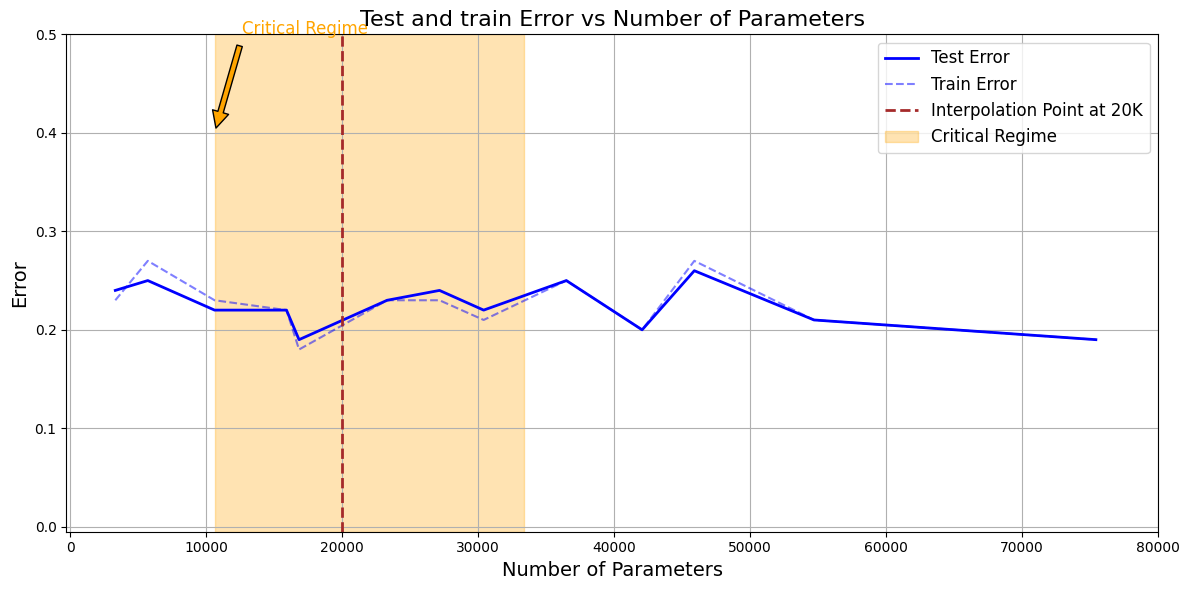

In [32]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the directory containing the results
directory = './result/'

# Prepare lists to collect data
param_counts = []
final_train_accuracies = []
final_test_accuracies = []
final_train_losses = []
final_test_losses = []

# List all subdirectories
subdirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
print(f"Found {len(subdirs)} subdirectories.")
# Iterate over each subdirectory to find and process the CSV files
for subdir in subdirs:
    subdir_path = os.path.join(directory, subdir)
    print(f"Processing {subdir_path}")
    # Extract the number of parameters from the directory name
    try:
        num_params = int(subdir)
        print(f"Number of parameters: {num_params}")
    except ValueError:
        # Skip directories that are not named after a number of parameters
        continue

    # Check for retrained results first
    retrained_csv_path = os.path.join(subdir_path, f"model_{subdir}_retrained_results.csv")
    original_csv_path = os.path.join(subdir_path, f"model_{subdir}_results.csv")

    if os.path.exists(retrained_csv_path):
        csv_path = retrained_csv_path
    elif os.path.exists(original_csv_path):
        csv_path = original_csv_path
    else:
        print(f"Warning: No results CSV found in {subdir_path}, skipping this model.")
        continue  # Skip if neither file exists

    # Read the CSV file
    df = pd.read_csv(csv_path)
    print(df.head())
    # Extract the final epoch's metrics
    try:
        final_train_accuracies.append((100 - df['train_accuracy'].max()) / 100)
        final_test_accuracies.append((100 - df['test_accuracy'][-5:].mean()) / 100)
        final_train_losses.append(df['train_loss'][-30:].min())
        final_test_losses.append(df['test_loss'][-30:].min())
        # Only append the number of parameters if all metrics are successfully appended
        param_counts.append(num_params)
    except KeyError:
        # Handle cases where expected columns are missing in the CSV
        print(f"Warning: Missing data in {csv_path}, skipping this model.")
        continue
print(f'final_test_accuracies: {final_test_accuracies}')
# Sort the results by the number of parameters
sorted_indices = sorted(range(len(param_counts)), key=lambda i: param_counts[i])
param_counts = np.array([param_counts[i] for i in sorted_indices])
final_train_accuracies = [final_train_accuracies[i] for i in sorted_indices]
final_test_accuracies = [final_test_accuracies[i] for i in sorted_indices]
final_train_losses = [final_train_losses[i] for i in sorted_indices]
final_test_losses = [final_test_losses[i] for i in sorted_indices]

# Plotting Test/Train Error vs Number of Parameters without interpolation
plt.figure(figsize=(12, 6))

# Plot the actual test and train error data points
plt.plot(param_counts, final_test_accuracies, '-', label='Test Error', color='blue', linewidth=2)
plt.plot(param_counts, final_train_accuracies, '--', label='Train Error', color='blue', alpha=0.5)

# Add the vertical line at 20,000 parameters for interpolation
plt.axvline(x=20000, color='brown', linestyle='--', linewidth=2, label='Interpolation Point at 20K')

# Highlight critical regime between 15k and 31k parameters
critical_start = 10608
critical_end = 33370
plt.axvspan(critical_start, critical_end, color='orange', alpha=0.3, label='Critical Regime')

# Add arrow and annotation for critical regime
plt.annotate('Critical Regime', xy=(critical_start, 0.4), xytext=(critical_start + 2000, 0.5),
             arrowprops=dict(facecolor='orange', shrink=0.05), fontsize=12, color='orange')

# Customizing the plot
plt.xlabel('Number of Parameters', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.ylim(-0.005, 0.16)
plt.title('Test and train Error vs Number of Parameters', fontsize=16)
plt.xticks(np.arange(0, param_counts.max() + 10000, step=10000))
plt.grid(True)
plt.legend(loc='best', fontsize=12)

# Show plot
plt.tight_layout()
plt.show()
